# **Convolutional Neural Network (CNN)**


실습 목표

1. Pytorch를 이용한 **Convolutional Neural Network(CNN)** 구현 및 **Multi-Layer Perceptron (MLP)**와의 비교 
2. 발전된 CNN 구조 (**VGG, ResNet**) 구현
3. 미리 정의된 CNN 구조 사용하기 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from tqdm import tqdm
import time 


##**1.Convolutional Neural Network(CNN)**

- CNN 및 convolutional layer는 이전까지의 실습에서 사용한 MLP (Multi-Layer Peceptron) 및 fully-connected layer와는 다른 특성을 갖는다.  
- Convolutional layer는 `torch.nn.Conv2d` 명령어를 이용해 정의할 수 있다.
- Convolutional layer는 정의시에 Linear layer와 다른 argument를 요구한다.
  - Linear layer의 경우, 정의시에 **input feature의 크기**와 **output feature의 크기**를 입력받는다.
  - Convolutional layer의 경우, 정의시에 **input channel의 크기**와 **output channel의 크기**, **kernel (filter)의 크기**를 필수적으로 입력받는다. 
- Convolutional layer는 Linear layer와 다른 형태의 weight를 이용한다.
  - Linear layer의 경우, 2차원의 matrix 형태(*output feature size, input feature size*)의 weight를 이용한다.
  - Convolutional layer의 경우, 4차원의 tensor 형태 (*output channel size, input channel size, kernel height, kernel width*)의 weight를 이용한다. 


In [ ]:
linear_layer = nn.Linear(in_features=784, out_features=400)
convolutional_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5))
print("Shape of Linear layer weight:" ,end=" ")
print(linear_layer.weight.shape)
print("Shape of Convolutional layer weight:", end=" ")
print(convolutional_layer.weight.shape)

이전 실습에서와 마찬가지로, `torchvision` 패키지를 이용해 MNIST 데이터셋을 로드한다. 

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=200, shuffle=False)

### **1.1.Pytorch를 이용한 CNN 구현**


`torch.nn.Conv2d`와 `torch.nn.MaxPool2d`, `torch.nn.Linear`를 이용해 다음과 같은 CNN을 구성한다. 
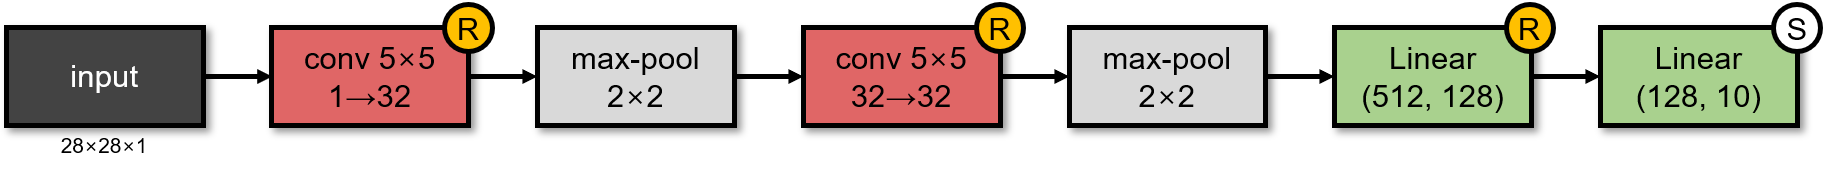

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # Convolution layer 구축 
    ##################################################
    self.conv1 = 
    #input channel 개수가 1, output channel의 개수가 32이며 kernel size가 5×5인 convolutional layer. 
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 입력된 feature를 2×2의 영역으로 나누어 나누어진 영역에서 최대값만을 남김으로써 feature의 height와 width를 모두 절반으로 줄이는 poioling layer
    self.conv2 = 
    #input channel 개수가 32, output channel의 개수가 32이며 kernel size가 5×5인 convolutional layer. 
    #kernel_size가 int일 경우 width와 height이 입력된 값으로 동일한 kernel이 이용된다. 

    self.fc1 = nn.Linear(in_features=512, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=10)# 최종 Linear layer의 output size는 10(클래스의 개수)로 설정 되어야 한다. 

  def forward(self, x):
    batchsize = x.size(0)
    x = self.pool(F.relu(self.conv1(x)))# Convolutional layer를 통과시키고 Relu function (Activation function)을 통과 시킨 후 pooling을 통해 size를 줄인다.
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(batchsize,-1)# Linear layer에 넣기 위해 shape을 ([batch_size, channels, height, width]) 에서 [batch_size, channels*height*width] 로 바꾼다.
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


모델의 학습과 평가를 위한 함수를 다음과 같이 정의한다.

`train` 함수를 이용해 모델을 학습시킬 수 있고, `evaluate` 함수를 통해 분류 accuracy를 측정할 수 있다.   

In [ ]:
def train(model, n_epoch, loader, optimizer, criterion, device="cpu"):
  model.train()
  for epoch in tqdm(range(n_epoch)):
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(input=outputs, target=labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print('Epoch {}, loss = {:.3f}'.format(epoch, running_loss/len(loader)))
  print('Training Finished')


In [ ]:
def evaluate(model, loader, device="cpu"):
  model.eval()
  total=0
  correct=0
  with torch.no_grad():
    for data in loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()
  acc = 100*correct/total
  return acc


정의한 CNN 모델을 train 함수를 이용해 학습한다.

CPU만을 이용하는 경우, Convolutional layer의 연산량이 많아 학습에 긴 시간이 필요하다.

In [ ]:
cnn_model = CNN()
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=1, loader=trainloader, optimizer=optimizer, criterion=criterion)

`train` 함수와 `evaluate` 함수를 이용해 정의한 CNN 모델을 학습하고 평가한다.  

GPU의 병렬 연산 기능을 이용할 경우, 학습시간이 대폭 단축되는 것을 확인할 수 있다.

- CNN은 kernel의 parameter를 feature의 모든 영역에 대해 공유하므로, 병렬 연산을 통해 연산 속도를 크게 높일 수 있다. 

In [ ]:
cnn_model = CNN().to("cuda")
optimizer = optim.SGD(params=cnn_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
train(model=cnn_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(cnn_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))


### **1.2.Multi-Layer Perceptron (MLP)와 CNN의 비교**

다양한 측면에서 MLP와 CNN의 차이점에 대한 비교를 진행한다
  - CNN은 MLP보다 많은 연산량 및 긴 학습 시간을 필요로 한다. 
  - CNN은 MLP에 비해 적은 수의 파라미터로 높은 성능을 확보할 수 있다.  

`torch.nn.Linear`를 이용해 다음과 같은 MLP를 구성한다.

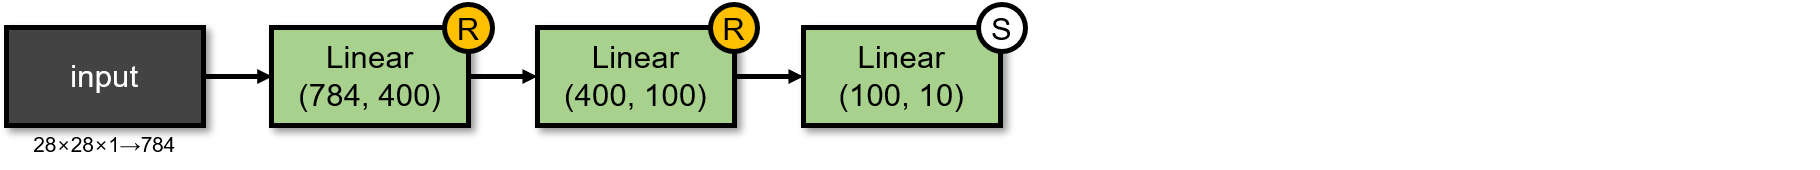

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(in_features=784, out_features=400)
    self.layer2 = nn.Linear(in_features=400, out_features=100)
    self.layer3 = nn.Linear(in_features=100, out_features=10)

  def forward(self, x):
    batchsize = x.size(0)
    x = x.view(batchsize, -1)
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)
    return x 

`train` 함수와 `evaluate` 함수를 이용해 정의한 MLP 모델을 학습하고 평가한다.  

  - CNN 모델과 비교했을 때 한 epoch에 적은 시간이 소요되는 것을 확인할 수 있다.
  - CNN 모델에 비해 학습 후의 accuracy가 낮은 것을 확인할 수 있다. 

In [ ]:
mlp_model = MLP().to("cuda")
optimizer = optim.SGD(params=mlp_model.parameters(), lr=0.001, momentum=0.9)
train(model=mlp_model, n_epoch=15, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
acc = evaluate(mlp_model, testloader, device="cuda")
print('Test accuracy: {:.2f}%'.format(acc))


실험에 사용한 MLP와 CNN의 파라미터 수를 비교한다.
  - CNN 모델이 MLP에 비해 적은 수의 파라미터로 높은 성능을 보이는 것을 확인할 수 있다.  

In [ ]:
mlp_num_parameters = sum(param.numel() for param in mlp_model.parameters() if param.requires_grad)
mlp_acc = evaluate(mlp_model, testloader, device="cuda")
print('Total Number of trainable parameters of MLP: {}, Accuracy of MLP: {:.2f}'.format(mlp_num_parameters, mlp_acc))

cnn_num_parameters = sum(param.numel() for param in cnn_model.parameters() if param.requires_grad)
cnn_acc = evaluate(cnn_model, testloader, device="cuda")
print('Total Number of trainable parameters of CNN: {}, Accuracy of CNN: {:.2f}'.format(cnn_num_parameters, cnn_acc))


##**2.발전된 CNN 구조 (VGG, ResNet) 구현**
- 2012년 AlexNet의 성공 이래로, 이미지의 분류 문제를 해결하기 위해 다양한 CNN 구조가 제안되어 왔다.
  - AlexNet, VGG, Inception, ResNet, Xception, ResNeXt 등
- 본 실습에서는 이 가운데 가장 많이 이용되는 2가지 예시(**VGG**, **ResNet**)를 구현하고 실험한다. 
  - 추가로, CNN에 Batch Normalization 기법을 적용하여 그 영향을 확인한다. 

`torchvision` 패키지를 이용해 **CIFAR10** 데이터셋을 로드한다. 

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=200, shuffle=False)

### **2.1 VGGNet**

- 신경망의 깊이가 성능에 미치는 영향을 파악하기 위해 개발된 신경망
- 동시대의 GoogleNet (Inception v1)에 비해 성능이 낮음에도, 구조가 간단하여 GoogleNet보다 다양한 분야에서 이용되고 있다. 
- VGGNet 구조에 적용된 요소들이 이후의 CNN 구조 개발에 영향을 미쳤다. 
  - 3×3 convolution layer를 주로 사용하고, receptive field(feature의 계산에 이용된 입력 이미지의 영역의 크기)를 증가시키기 위해서 kernel size가 아닌 신경망의 깊이를 증가시킨다. 
  - Padding을 통해 convolutional layer에서 feature의 크기(height, width)의 변화가 일어나지 않게 하고, feature의 크기는 pooling을 이용해 조정한다. 
  - Channel의 크기를 $2^n$으로 유지하고, pooling 이후에 channel의 크기를 2배로 증가시킨다.

In [ ]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) #3×3의 kernel size를 갖는 convolutional layer를 이용, padding이 적용되어 feature 크기의 변화 없음. 
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Feature의 크기를 변화시키기 위한 pooling layer. 
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) #본래 VGG 구조에는 없는 average pooling layer. 실습에서 이용할 구조를 간단히 하기 위해 이용하였음. 

    self.fc = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max_pool(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.max_pool(x)

    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = self.avg_pool(x)
    x = x.view(-1,128)
    x = self.fc(x)
    return x

`train` 함수와 `evaluate` 함수를 이용해 정의한 VGG 모델을 학습하고 평가한다.





In [ ]:
vgg_model = VGG().to("cuda")
optimizer = optim.SGD(params=vgg_model.parameters(), lr=0.01, momentum=0.9)
train(model=vgg_model, n_epoch=30, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")


In [ ]:
vgg_acc = evaluate(vgg_model, testloader, device="cuda")
print('VGG Test accuracy: {:.2f}%'.format(vgg_acc))

### **2.2 Residual Network (ResNet)**
- 보다 깊은 신경망을 학습시키기 위하여 skip connection을 도입한 CNN 구조
  - Skip connection을 통해 신경망의 깊이 증가로 인해 발생하는 gradient vanishing 문제를 해결함 
  - 별도의 연산량 증가 없이 성능의 향상을 달성할 수 있다.
- Skip connection을 통해 낮은 layer의 feature를 높은 layer에서 직접 이용할 수 있게 된다.
  - 기존 신경망 (VGG 등)과 비슷한 수준의 깊이에서도 skip connection으로 인한 성능 향상이 가능하다. 

In [ ]:
class ResNet(nn.Module):
  def __init__(self):
    super(ResNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # VGGNet과의 비교를 위해 이전에 구성한 VGG와 동일한 크기의 파라미터를 갖도록 신경망을 구성함 
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))

    self.fc = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    # Residual Connection 구현
    # input channel과 output channel의 수가 같은 conv2, conv4, conv6에서 residual connection을 추가함 
    ##################################################
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x)) 
    x = self.max_pool(x)

    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.max_pool(x)

    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x)) 
    x = self.avg_pool(x)
    x = x.view(-1,128)

    x = self.fc(x)
    return x

`train` 함수와 `evaluate` 함수를 이용해 정의한 ResNet 모델을 학습하고 평가한다.

VGG 모델과 동일한 수의 파라미터와 비슷한 연산 시간으로 높은 성능을 달성할 수 있다.  


In [ ]:
resnet_model = ResNet().to("cuda")
optimizer = optim.SGD(params=resnet_model.parameters(), lr=0.01, momentum=0.9)
train(model=resnet_model, n_epoch=30, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")


In [ ]:
resnet_acc = evaluate(resnet_model, testloader, device="cuda")
print('ResNet Test accuracy: {:.2f}%'.format(resnet_acc))

### **2.3 Batch Normalization (BatchNorm) 적용하기**

- 신경망의 학습 과정에서 각 layer마다 입력 값의 분포가 달라지는 것을 방지하기 위한 기술 
  - Layer마다 normalization을 수행하여 각 layer의 activation 함수들의 입력값이 위치하는 영역을 조절해 gradient 값이 사라지지 않도록 조절한다.
  - Normalization으로 인한 신경망의 표현력 저하를 방지하기 위하여 각 layer에 적합한 mean과 variance를 학습할 수 있도록 한다. (학습 파라미터가 소량 증가).
  - 학습 속도가 개선되며, overfitting이 방지되는 효과가 있다. 
  - `torch.nn.BatchNorm2d`를 이용해 batch normalization layer를 추가한다.
  - Batch normalization layer의 정의시에 입력값으로 channel의 수를 입력 받는다.  
  - Mean과 variance 각각에 대해서 channel의 수 만큼 학습 파라미터가 추가된다. 

In [ ]:
class ResNet_BN(nn.Module):
  def __init__(self):
    super(ResNet_BN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.norm1= nn.BatchNorm2d(32) #channel 개수가 32인 batch normalization layer.
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
    self.norm2= nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.norm3= nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    self.norm4= nn.BatchNorm2d(64)

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    self.norm5= nn.BatchNorm2d(128)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.norm6= nn.BatchNorm2d(128)

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1))

    self.fc = nn.Linear(in_features=128, out_features=10)

  def forward(self, x):
    x = F.relu(self.norm1(self.conv1(x))) # 각 layer에서 activation 전에 normalization을 적용 
    x_residual = x
    x = F.relu(self.norm2(self.conv2(x))+x_residual)
    x = self.max_pool(x)

    x = F.relu(self.norm3(self.conv3(x)))
    x_residual = x
    x = F.relu(self.norm4(self.conv4(x))+x_residual)
    x = self.max_pool(x)

    x = F.relu(self.norm5(self.conv5(x)))
    x_residual = x
    x = F.relu(self.norm6(self.conv6(x))+x_residual)
    x = self.avg_pool(x)
    x = x.view(-1,128)

    x = self.fc(x)
    return x

`train` 함수와 `evaluate` 함수를 이용해 정의한 Batch normalization을 추가한  ResNet 모델을 학습하고 평가한다.

Batch normalization의 도입을 통해 적은 양의 파라미터 증가로 상당한 수준의 성능 증가를 달성할 수 있다. 

In [ ]:
resnet_bn_model = ResNet_BN().to("cuda")
optimizer = optim.SGD(params=resnet_bn_model.parameters(), lr=0.01, momentum=0.9)
train(model=resnet_bn_model, n_epoch=30, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")


In [ ]:
resnet_bn_acc = evaluate(resnet_bn_model, testloader, device="cuda")
print('ResNet + BN Test accuracy: {:.2f}%'.format(resnet_bn_acc))

## **3.미리 정의된 CNN 구조 사용하기** 
- 많은 layer를 가진 발전된 구조의 CNN은 높은 성능을 보이나, 이를 필요할 때 매번 정의하기에는 번거로움이 있다.
- 또한, 신경망의 크기가 커질수록 학습에 오랜 시간과 많은 양의 데이터가 필요하다.
- Pytorch는 사용자가 이와 같은 문제를 겪지 않도록 `torchvision` 패키지를 이용해 잘 알려진 CNN 구조들을 정의하여 제공하고 있다.
  - AlexNet, VGG, ResNet, Inception, GoogleNet, ResNext, Wide ResNet 등 다양한 CNN 구조들을 제공한다.
  - 각 CNN 구조는 기본적으로 1000개 class를 구분하는 구조로 제공되며, `num_classes` argument를 통해 구분할 class의 개수를 변경할 수 있다. 

In [ ]:
import torchvision.models as models
alexnet = models.alexnet()
vgg16 = models.vgg16() #vgg11, vgg13, vgg16, vgg19와 batchnorm을 적용한 vgg11_bn, vgg13_bn, vgg16_bn, vgg19_bn의 variation이 제공됨 
resnet18 = models.resnet18() #resnet18, resnet34, resnet50, resnet101, resnet152의 variation이 제공됨 
resnext50_32x4d = models.resnext50_32x4d() #resnext50_32x4d, resnext101_32x8d의 variation이 제공됨 
wide_resnet50_2 = models.wide_resnet50_2() #wide_resnet50_2, wide_resnet101_2의 variation이 제공됨 

  - Pytorch는 또한 각 CNN 구조들을 ImageNet 데이터셋에서 사전학습한 모델을 제공한다.
    - 사전학습된 모델은 다양한 computer vision 문제의 feature 추출기로 유용하게 사용된다.

In [ ]:
alexnet = models.alexnet(pretrained=True)
vgg16 = models.vgg16(pretrained=True) 
resnet18 = models.resnet18(pretrained=True) 
resnext50_32x4d = models.resnext50_32x4d(pretrained=True) 
wide_resnet50_2 = models.wide_resnet50_2(pretrained=True) 

  - CIFAR 10 데이터셋에 적절한 전처리와 data augmentation을 추가하여 데이터셋을 불러온다.
    - RandomCrop: 큰 이미지의 일부분을 잘라 새로운 데이터를 만드는 data augmentation
    - RandomHorizontalFlip: 이미지를 random하게 상하로 반전시켜 데이터를 늘리는 data augmentation
    - Normalize: CIFAR10의 training set의 mean과 stadard deviation을 이용해 데이터를 normalize한다.
    - Test set의 경우, RandomCrop과 RandomHorizontalFlip을 통한 data augmentation은 적용하지 않는다. 

In [ ]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=200, shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=200, shuffle=False)

- `torchvision` 패키지에서 제공하는 CNN 구조를 이용해 다음과 같이 CNN 모델을 정의하고 학습시킬 수 있다.

In [ ]:
vgg16 = models.vgg16(num_classes = 10).to("cuda")
optimizer = optim.SGD(params=vgg16.parameters(), lr=0.01, momentum=0.9)
train(model=vgg16, n_epoch=1, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
vgg16_acc = evaluate(vgg16, testloader, device="cuda")
print('VGG-16 Test accuracy: {:.2f}%'.format(vgg16_acc))
torch.save({'model_state_dict':vgg16.state_dict()},'save.tar')

In [ ]:
!pip install gdown
!gdown --id 1eeGKlJlRZXvCbT8icq_xW0vyfTvXvEEQ

checkpoint = torch.load('VGG16.tar', map_location = 'cuda')
vgg16.load_state_dict(checkpoint['model_state_dict'])
vgg16_acc = evaluate(vgg16, testloader, device="cuda")
print('VGG-16 Test accuracy: {:.2f}%'.format(vgg16_acc))

In [ ]:
resnet18 = models.resnet18(num_classes = 10).to("cuda")
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False).to("cuda") # CIFAR10에 맞게 model의 kernel size 및 stride를 조정.
optimizer = optim.SGD(params=resnet18.parameters(),  lr=0.01, momentum=0.9)
train(model=resnet18, n_epoch=1, loader=trainloader, optimizer=optimizer, criterion=criterion, device="cuda")
resnet18_acc = evaluate(resnet18, testloader, device="cuda")
print('ResNet-18 Test accuracy: {:.2f}%'.format(resnet18_acc))

In [ ]:
!gdown --id 1GDyJY7twabVhtJ2Qrq8dRvWqrlh4jlKg

checkpoint = torch.load('ResNet18.tar', map_location = 'cuda')
resnet18.load_state_dict(checkpoint['model_state_dict'])
resnet18_acc = evaluate(resnet18, testloader, device="cuda")
print('ResNet-18 Test accuracy: {:.2f}%'.format(resnet18_acc))